----- Split Summary (based on label_year = fyear+1) -----
Train label_year max: 2021 | n=44783
Val   label_years: [np.int64(2022)] | n=6415
Test  label_year min: 2023 | n=12404


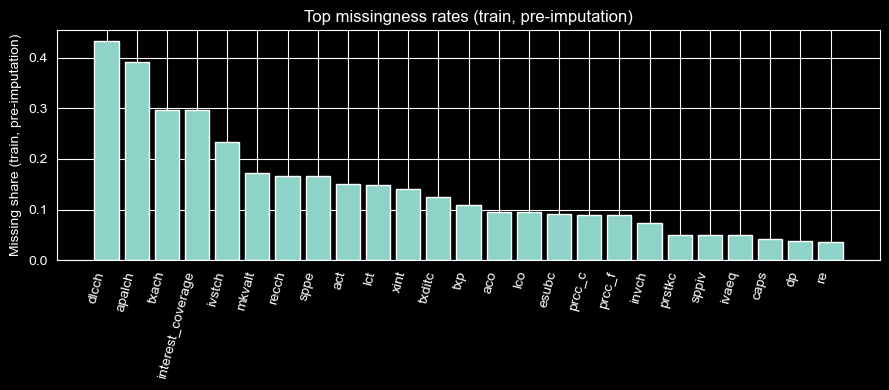

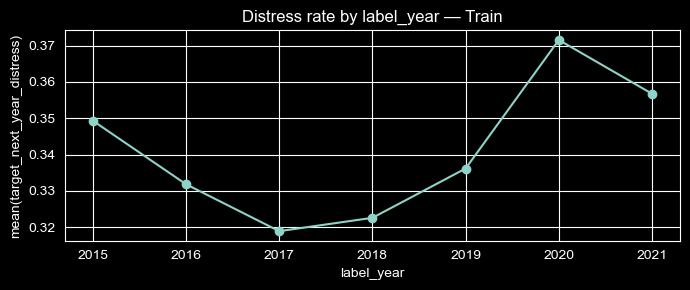

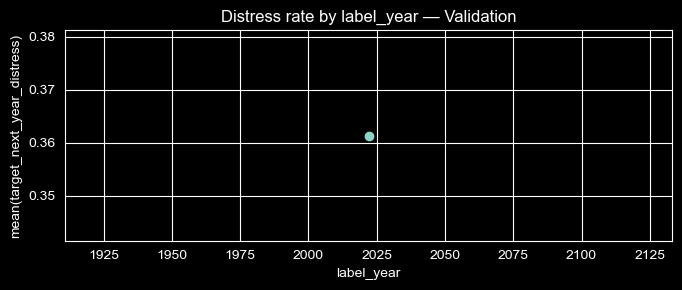

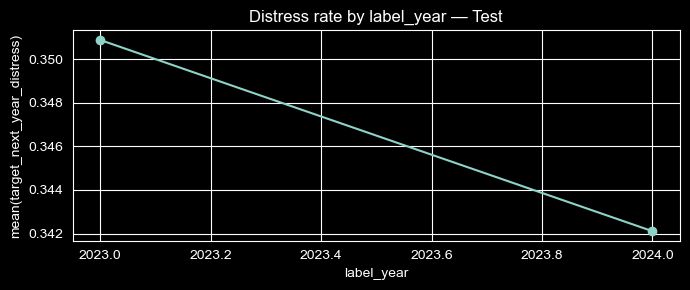


----- EDA: Raw summary stats (TRAIN) -----
         count          mean           std         min         1%       5%  \
at     44783.0  5.653617e+06  7.110160e+07         0.0       1.00     78.0   
che    44783.0  8.242080e+05  1.548455e+07     -1346.0       0.00      4.0   
dltt   44783.0  9.512560e+05  8.837958e+06         0.0       0.00      0.0   
dlc    44783.0  3.858271e+05  7.584755e+06         0.0       0.00      0.0   
seq    44783.0  9.581475e+05  6.205144e+06 -13770506.0 -137958.28  -4457.0   
oibdp  44783.0  2.447771e+05  1.842727e+06  -4989766.0 -145073.34 -30625.8   
xint   44783.0  2.405593e+04  1.139966e+05     -1512.0       0.00      0.0   

           50%        95%          99%           max  
at     93775.0  9380951.1  56726110.18  3.199077e+09  
che    10450.5   875561.9   6644269.38  1.058786e+09  
dltt    2415.0  2384166.0  12351361.26  3.105516e+08  
dlc      305.0   349782.0   3585775.62  6.142374e+08  
seq    34991.0  2911785.5  16081304.94  2.019972e+08  
o

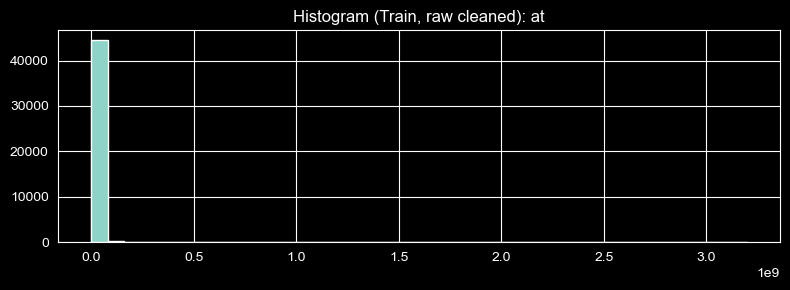

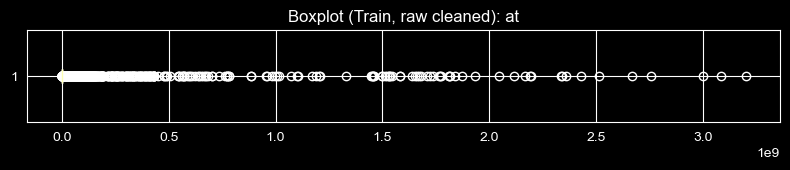

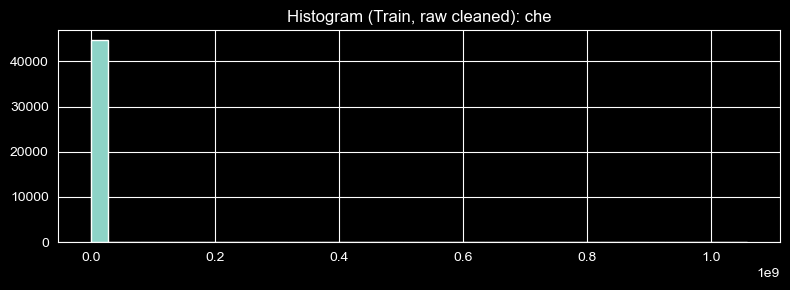

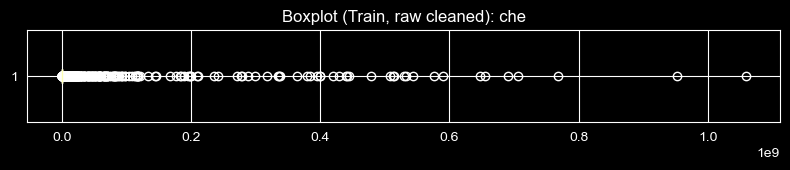

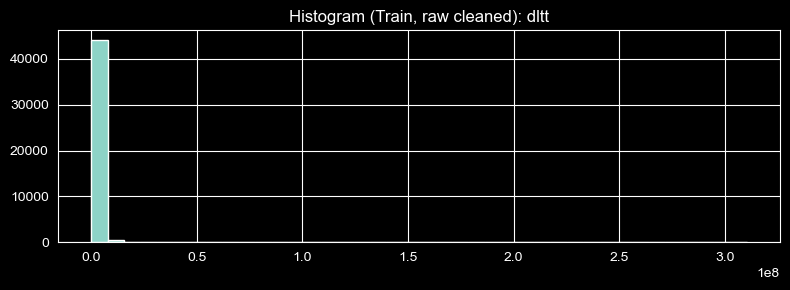

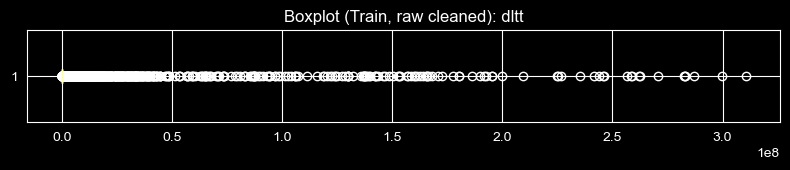

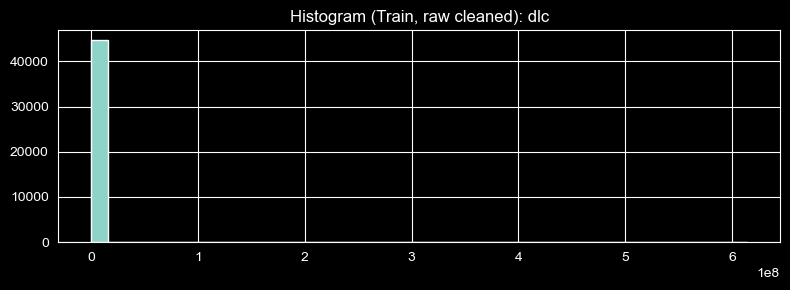

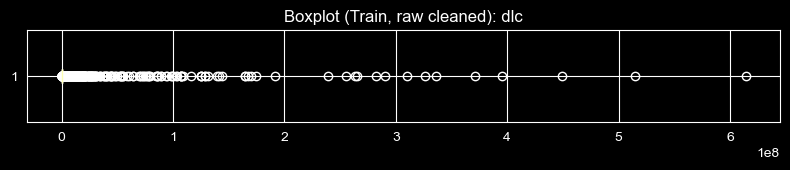

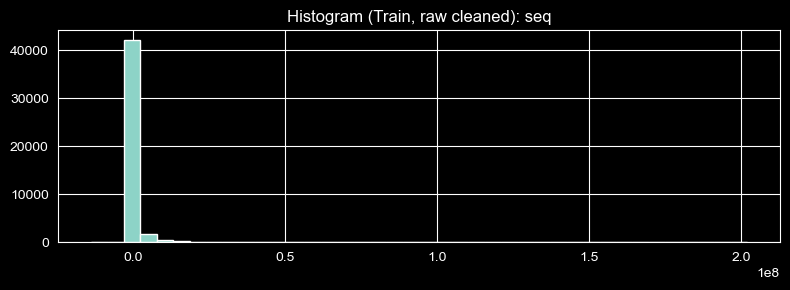

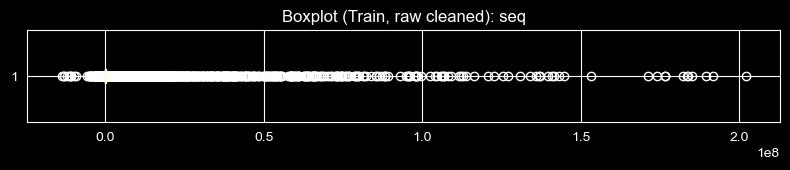

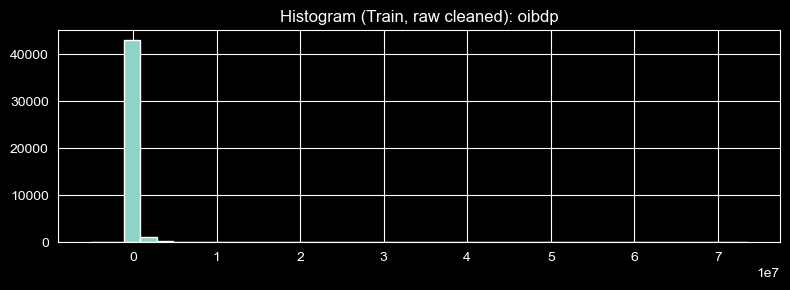

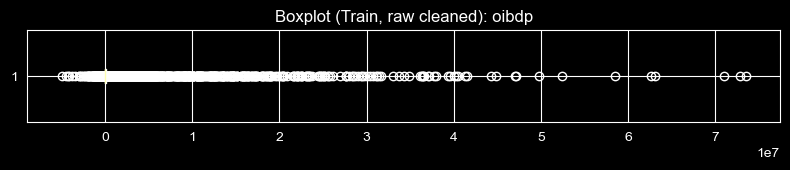

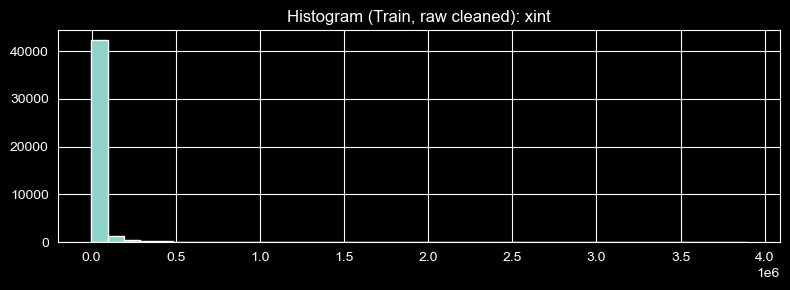

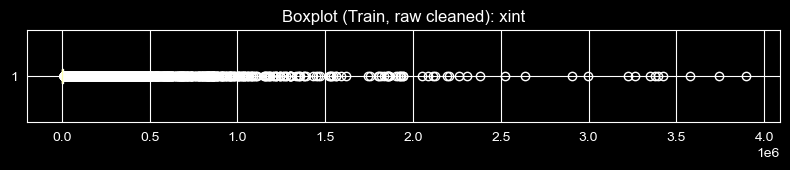

In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# 0. CONFIGURATION
# =============================================================================
FILE_NAME = "data.csv"

# IMPORTANT: because target is t+1, we split by label_year = fyear + 1
TRAIN_CUTOFF_LABEL_YEAR = 2022     # Train/Val labels up to and incl. 2022, Test labels after 2022
VAL_YEARS = 1                      # Hold out the last 1 label-year from the training pool as validation

# Rolling year-based CV folds (within train_pool)
N_SPLITS_TIME_CV = 5

# Preprocessing
WINSOR_LOWER_Q = 0.01
WINSOR_UPPER_Q = 0.99
EPS = 1e-8

# Missing values handling (Data Cleaning step)
APPLY_PANEL_FFILL = True           # within-firm forward-fill (uses past values only)
APPLY_TRAIN_MEDIAN_IMPUTE = True   # remaining NaNs -> train medians (leakage-safe)

NUMERIC_COLS = [
    'prcc_c', 'prcc_f', 'gvkey', 'fyear', 'ismod',
    'ib', 'at', 'dltt', 'dlc', 'che', 're', 'seq',
    'xrd', 'dv', 'sale', 'ni', 'act', 'lct', 'oancf', 'ivncf', 'fincf',
    'oibdp', 'xint', 'mkvalt', 'capx'
]

REQUIRED_KEYS = ['gvkey', 'fyear']

# =============================================================================
# 1. HELPERS
# =============================================================================
def _ensure_required_columns(df, required):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required column(s): {missing}. Check your CSV schema.")
    return True

def _safe_div(numer, denom, eps=EPS):
    numer = pd.to_numeric(numer, errors='coerce')
    denom = pd.to_numeric(denom, errors='coerce')
    return numer / (denom + eps)

def _panel_forward_fill(df, cols, firm_col='firm_id', time_col='fyear'):
    # forward-fill only (past -> future). Assumes sorted by (firm, time).
    if df.empty:
        return df
    cols = [c for c in cols if c in df.columns]
    if not cols:
        return df
    df = df.sort_values([firm_col, time_col]).copy()
    df[cols] = df.groupby(firm_col, sort=False)[cols].ffill()
    return df

def _fit_medians(train_df, cols):
    med = {}
    for c in cols:
        s = pd.to_numeric(train_df[c], errors='coerce')
        med[c] = s.median(skipna=True)
    return med

def _apply_median_impute(df, medians):
    for c, m in medians.items():
        if c in df.columns and np.isfinite(m):
            s = pd.to_numeric(df[c], errors='coerce')
            df[c] = s.fillna(m)
    return df

def _add_log_features(df, cols):
    for c in cols:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors='coerce')
            # log1p requires >= 0; negative values become NaN
            m = s >= 0
            out = pd.Series(np.nan, index=df.index, dtype='float64')
            out.loc[m] = np.log1p(s.loc[m])
            df[f'log_{c}'] = out
    return df

def _fit_winsor_bounds(train_df, cols, q_lo=WINSOR_LOWER_Q, q_hi=WINSOR_UPPER_Q):
    bounds = {}
    for c in cols:
        s = pd.to_numeric(train_df[c], errors='coerce')
        if s.notna().sum() == 0:
            bounds[c] = (np.nan, np.nan)
        else:
            bounds[c] = (s.quantile(q_lo), s.quantile(q_hi))
    return bounds

def _apply_winsor(df, bounds):
    for c, (lo, hi) in bounds.items():
        if c in df.columns and np.isfinite(lo) and np.isfinite(hi):
            s = pd.to_numeric(df[c], errors='coerce')
            df[c] = s.clip(lower=lo, upper=hi)
    return df

def _fit_scaler(train_df, cols):
    stats = {}
    for c in cols:
        s = pd.to_numeric(train_df[c], errors='coerce')
        mu = s.mean()
        sd = s.std(ddof=0)
        stats[c] = (mu, sd if np.isfinite(sd) and sd > 0 else np.nan)
    return stats

def _apply_zscore(df, stats, prefix="z_"):
    for c, (mu, sd) in stats.items():
        if c in df.columns:
            s = pd.to_numeric(df[c], errors='coerce')
            if np.isfinite(sd) and sd > 0:
                df[f"{prefix}{c}"] = (s - mu) / (sd + EPS)
            else:
                df[f"{prefix}{c}"] = np.nan
    return df

def _add_ratio_features(df):
    # Ratios / engineered fundamentals
    df = df.copy()

    # interest coverage: oibdp / xint (avoid xint<=0)
    df['interest_coverage'] = np.nan
    if all(c in df.columns for c in ['oibdp', 'xint']):
        xint = pd.to_numeric(df['xint'], errors='coerce')
        cov = _safe_div(df['oibdp'], df['xint'])
        cov = cov.where(xint > 0, np.nan)
        df['interest_coverage'] = cov

    df['roa'] = np.nan
    df['cf_roa'] = np.nan
    if all(c in df.columns for c in ['ib', 'at']):
        df['roa'] = _safe_div(df['ib'], df['at'])
    if all(c in df.columns for c in ['oancf', 'at']):
        df['cf_roa'] = _safe_div(df['oancf'], df['at'])

    # total debt
    if ('dltt' in df.columns) or ('dlc' in df.columns):
        debt_parts = []
        if 'dltt' in df.columns:
            debt_parts.append(pd.to_numeric(df['dltt'], errors='coerce'))
        if 'dlc' in df.columns:
            debt_parts.append(pd.to_numeric(df['dlc'], errors='coerce'))
        df['total_debt'] = pd.concat(debt_parts, axis=1).sum(axis=1, min_count=1)
    else:
        df['total_debt'] = np.nan

    df['leverage'] = np.nan
    df['debt_to_equity'] = np.nan
    if all(c in df.columns for c in ['total_debt', 'at']):
        df['leverage'] = _safe_div(df['total_debt'], df['at'])
    if all(c in df.columns for c in ['total_debt', 'seq']):
        df['debt_to_equity'] = _safe_div(df['total_debt'], df['seq'])

    df['current_ratio'] = np.nan
    df['cash_ratio'] = np.nan
    if all(c in df.columns for c in ['act', 'lct']):
        df['current_ratio'] = _safe_div(df['act'], df['lct'])
    if all(c in df.columns for c in ['che', 'lct']):
        df['cash_ratio'] = _safe_div(df['che'], df['lct'])

    df['re_to_assets'] = np.nan
    df['mkt_to_book'] = np.nan
    if all(c in df.columns for c in ['re', 'at']):
        df['re_to_assets'] = _safe_div(df['re'], df['at'])
    if all(c in df.columns for c in ['mkvalt', 'seq']):
        df['mkt_to_book'] = _safe_div(df['mkvalt'], df['seq'])

    df['capex_ratio'] = np.nan
    if all(c in df.columns for c in ['capx', 'at']):
        df['capex_ratio'] = _safe_div(df['capx'], df['at'])

    return df

# =============================================================================
# 2. LOAD + LABEL/TARGET CONSTRUCTION (Needed before Cleaning/EDA)
# =============================================================================
df = pd.read_csv(FILE_NAME, low_memory=False)
_ensure_required_columns(df, REQUIRED_KEYS)

# 2.1 Datetime conversion
if 'datadate' in df.columns:
    df['datadate'] = pd.to_datetime(df['datadate'], errors='coerce')

# 2.2 Numeric conversion
for col in NUMERIC_COLS:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 2.3 Keys, sort, duplicates
df = df.dropna(subset=['gvkey', 'fyear']).copy()
df['firm_id'] = df['gvkey'].astype(str)
df['fyear'] = pd.to_numeric(df['fyear'], errors='coerce').astype(int)

df = df.sort_values(['firm_id', 'fyear']).reset_index(drop=True)
df = df.drop_duplicates(subset=['firm_id', 'fyear'], keep='last').reset_index(drop=True)

# 2.4 label_year and distress definition at time t
df['label_year'] = df['fyear'] + 1

# distress_dummy at time t (coverage < 1 OR seq < 0)
df_tmp = _add_ratio_features(df[['firm_id', 'fyear', 'label_year'] + [c for c in df.columns if c in ['oibdp','xint','seq']]].copy())
df['interest_coverage'] = df_tmp['interest_coverage']

cond_coverage = (pd.to_numeric(df['interest_coverage'], errors='coerce') < 1.0)
cond_insolvency = (pd.to_numeric(df['seq'], errors='coerce') < 0) if 'seq' in df.columns else pd.Series(False, index=df.index)

df['distress_dummy'] = (cond_coverage.fillna(False) | cond_insolvency.fillna(False)).astype(int)

# Target: next-year distress (t+1) aligned with label_year = fyear+1
df = df.sort_values(['firm_id', 'fyear']).reset_index(drop=True)
df['target_next_year_distress'] = df.groupby('firm_id', sort=False)['distress_dummy'].shift(-1)

# drop last firm-year obs where next-year label is not observable
df = df.dropna(subset=['target_next_year_distress']).reset_index(drop=True)
df['target_next_year_distress'] = df['target_next_year_distress'].astype(int)

# 2.5 Train/Val/Test split (needed for leakage-safe Cleaning/FE)
train_pool = df[df['label_year'] <= TRAIN_CUTOFF_LABEL_YEAR].copy()
test = df[df['label_year'] > TRAIN_CUTOFF_LABEL_YEAR].copy()

if train_pool.empty:
    raise ValueError("Training pool is empty after applying label_year cutoff. Check TRAIN_CUTOFF_LABEL_YEAR.")

unique_label_years = np.sort(train_pool['label_year'].dropna().unique())
val_years = unique_label_years[-VAL_YEARS:] if len(unique_label_years) >= VAL_YEARS else unique_label_years

val = train_pool[train_pool['label_year'].isin(val_years)].copy()
train = train_pool[~train_pool['label_year'].isin(val_years)].copy()

print("----- Split Summary (based on label_year = fyear+1) -----")
print(f"Train label_year max: {train['label_year'].max()} | n={len(train)}")
print(f"Val   label_years: {list(val_years)} | n={len(val)}")
print(f"Test  label_year min: {test['label_year'].min() if not test.empty else None} | n={len(test)}")

# =============================================================================
# 3. DATA CLEANING (Missing values, duplicates, inconsistencies)
# =============================================================================
# 3.1 Basic validation checks
_ensure_required_columns(train, REQUIRED_KEYS)
_ensure_required_columns(val, REQUIRED_KEYS)
if not test.empty:
    _ensure_required_columns(test, REQUIRED_KEYS)

# 3.2 Missingness snapshot BEFORE cleaning (for EDA plots later)
train_missing_before = train.isna().mean().sort_values(ascending=False)

# 3.3 Handle missing values (leakage-safe)
#     (i) optional within-firm forward-fill (uses only earlier years within each split)
#     (ii) optional remaining NaNs -> train medians (fit on TRAIN only; apply to VAL/TEST)
raw_impute_cols = [c for c in NUMERIC_COLS if c in df.columns]
raw_impute_cols = [c for c in raw_impute_cols if c not in ['gvkey', 'fyear']]  # keep ids/keys out

if APPLY_PANEL_FFILL:
    train = _panel_forward_fill(train, raw_impute_cols, firm_col='firm_id', time_col='fyear')
    val   = _panel_forward_fill(val,   raw_impute_cols, firm_col='firm_id', time_col='fyear')
    test  = _panel_forward_fill(test,  raw_impute_cols, firm_col='firm_id', time_col='fyear')

if APPLY_TRAIN_MEDIAN_IMPUTE:
    medians_raw = _fit_medians(train, raw_impute_cols)
    train = _apply_median_impute(train, medians_raw)
    val   = _apply_median_impute(val,   medians_raw)
    test  = _apply_median_impute(test,  medians_raw)

# 3.4 Final duplicate safety (should already be clean, but enforce)
train = train.drop_duplicates(subset=['firm_id', 'fyear'], keep='last').reset_index(drop=True)
val   = val.drop_duplicates(subset=['firm_id', 'fyear'], keep='last').reset_index(drop=True)
test  = test.drop_duplicates(subset=['firm_id', 'fyear'], keep='last').reset_index(drop=True)

# =============================================================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================
# 4.1 Missingness (train, BEFORE imputation) — top 25
top_miss = train_missing_before.head(25)

plt.figure(figsize=(9, 4))
plt.bar(range(len(top_miss)), top_miss.values)
plt.xticks(range(len(top_miss)), top_miss.index, rotation=75, ha='right')
plt.ylabel("Missing share (train, pre-imputation)")
plt.title("Top missingness rates (train, pre-imputation)")
plt.tight_layout()
plt.show()

# 4.2 Distress rate by label_year (train/val/test)
def plot_distress_rate(split_df, name):
    if split_df is None or split_df.empty:
        return
    g = split_df.groupby('label_year')['target_next_year_distress'].mean()
    plt.figure(figsize=(7, 3))
    plt.plot(g.index, g.values, marker='o')
    plt.title(f"Distress rate by label_year — {name}")
    plt.xlabel("label_year")
    plt.ylabel("mean(target_next_year_distress)")
    plt.tight_layout()
    plt.show()

plot_distress_rate(train, "Train")
plot_distress_rate(val, "Validation")
plot_distress_rate(test, "Test")

# 4.3 Summary statistics + distribution checks on selected raw columns (train)
eda_raw_vars = [c for c in ['at', 'sale', 'ni', 'che', 'dltt', 'dlc', 'seq', 'oibdp', 'xint'] if c in train.columns]

print("\n----- EDA: Raw summary stats (TRAIN) -----")
if eda_raw_vars:
    print(train[eda_raw_vars].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T)
else:
    print("No EDA raw vars available in training set.")

for c in eda_raw_vars:
    s = pd.to_numeric(train[c], errors='coerce').dropna()
    if s.empty:
        continue

    plt.figure(figsize=(8, 3))
    plt.hist(s.values, bins=40)
    plt.title(f"Histogram (Train, raw cleaned): {c}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 1.8))
    plt.boxplot(s.values, vert=False)
    plt.title(f"Boxplot (Train, raw cleaned): {c}")
    plt.tight_layout()
    plt.show()

Winsorization done (bounds fit on TRAIN only).
Standardization done (stats fit on TRAIN only).

----- Correlation with Target (TRAIN; standardized engineered features) -----
z_roa                     r = -0.1501
z_cf_roa                  r = -0.1403
z_leverage                r =  0.0912
z_debt_to_equity          r = -0.0261
z_current_ratio           r = -0.0008
z_cash_ratio              r = -0.0165
z_re_to_assets            r = -0.1475
z_mkt_to_book             r = -0.0739
z_capex_ratio             r =  0.0260
z_interest_coverage       r = -0.1313
z_log_at                  r = -0.3075
z_log_mkvalt              r = -0.2703
miss_roa                  r =  nan
miss_cf_roa               r =  nan
miss_leverage             r =  nan
miss_debt_to_equity       r =  nan
miss_current_ratio        r =  nan
miss_cash_ratio           r =  nan
miss_re_to_assets         r =  nan
miss_mkt_to_book          r =  nan
miss_capex_ratio          r =  nan
miss_interest_coverage    r = -0.0826
miss_log_at      

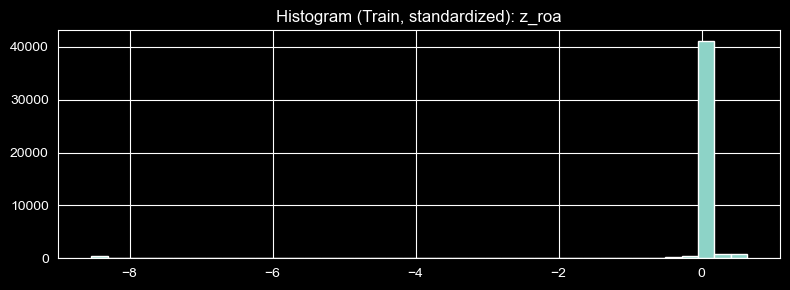

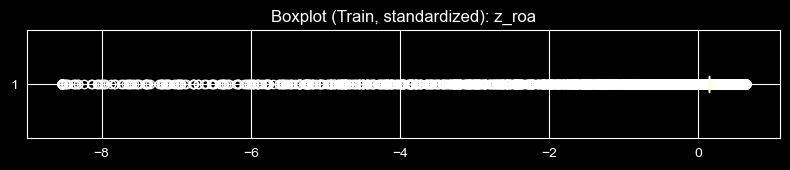

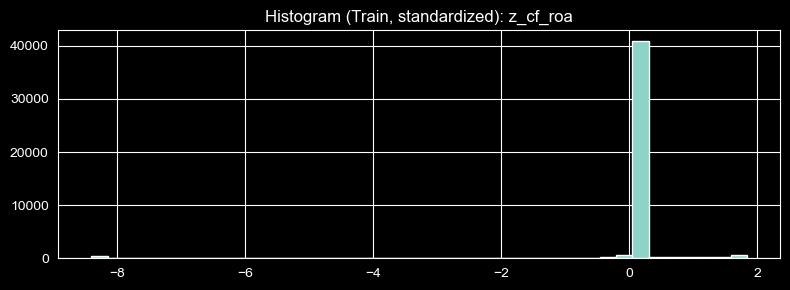

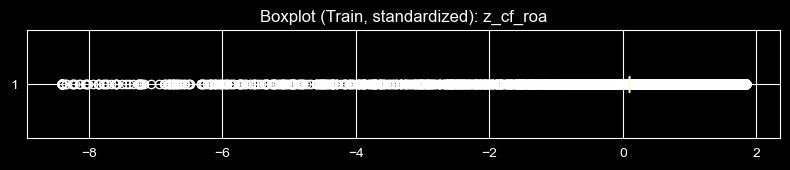

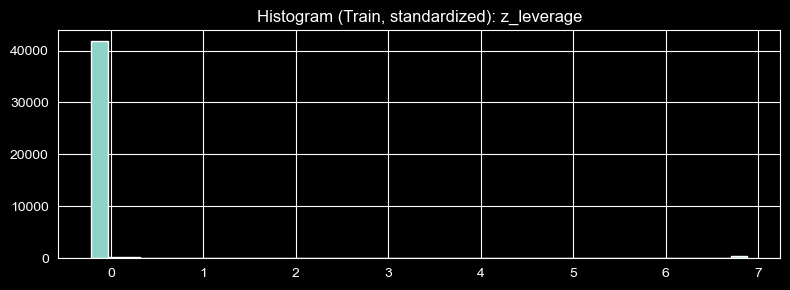

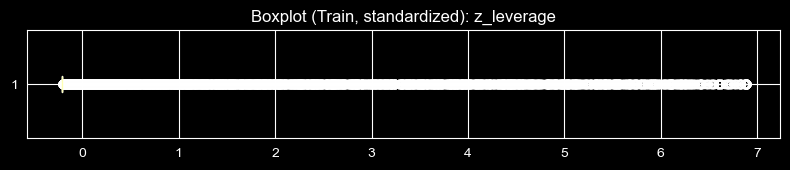

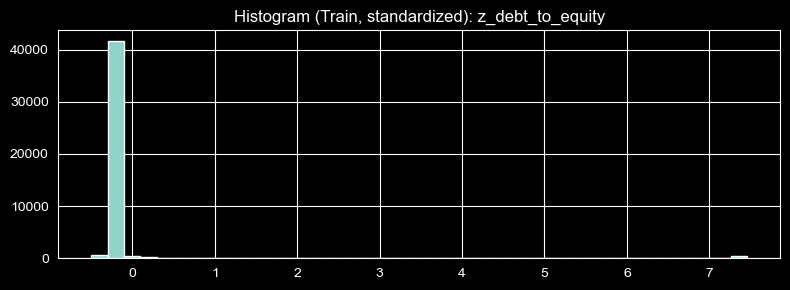

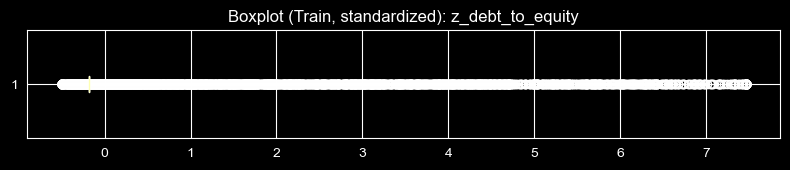

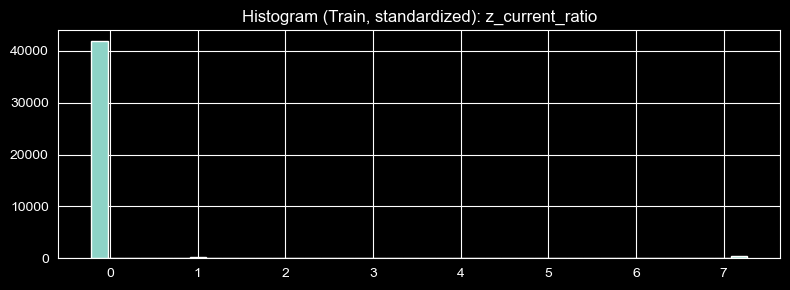

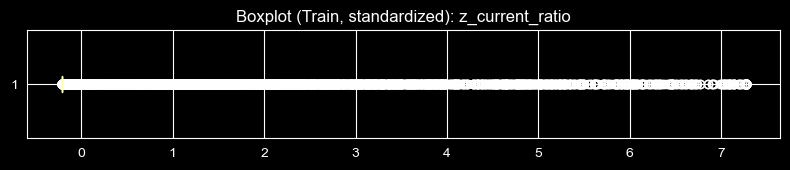

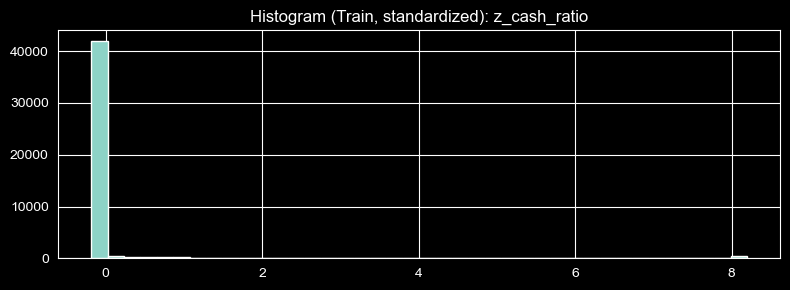

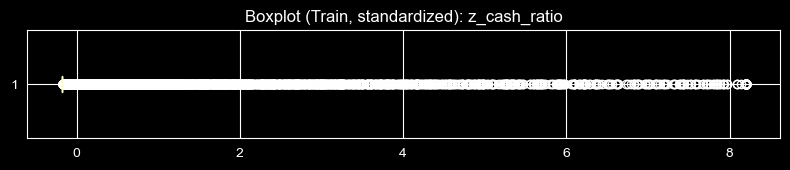

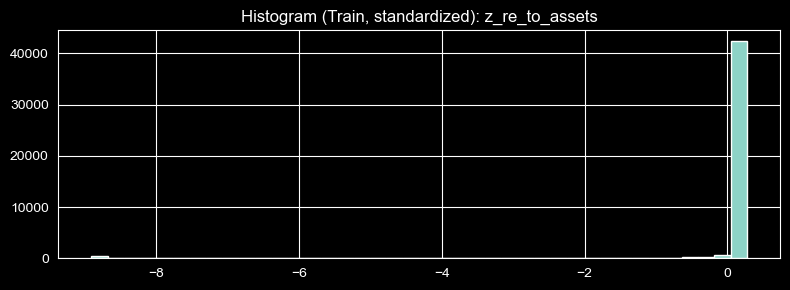

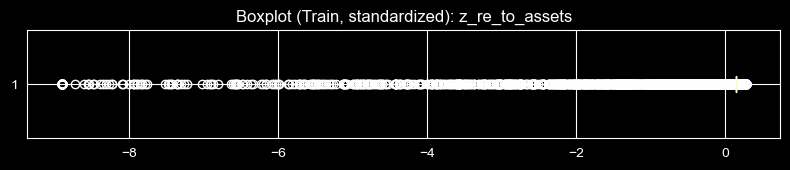

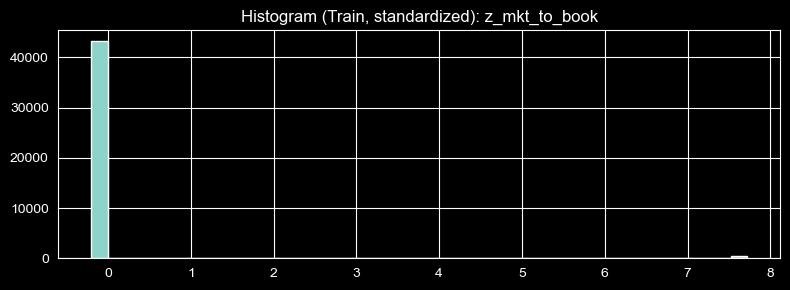

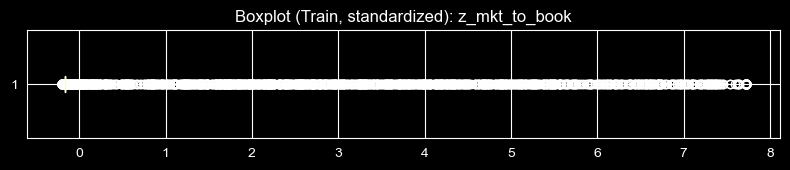

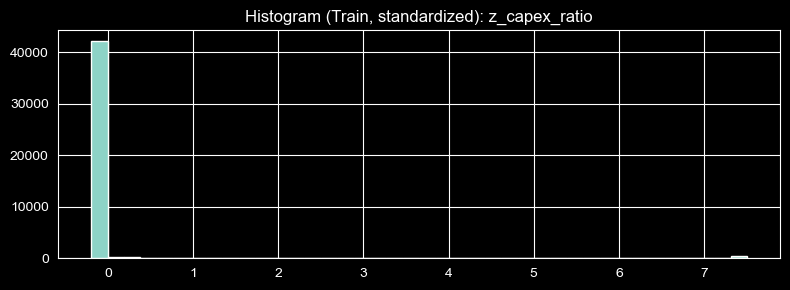

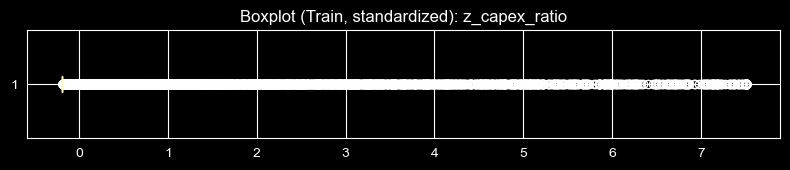

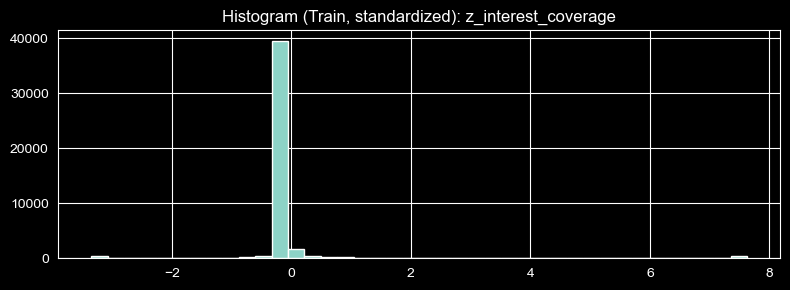

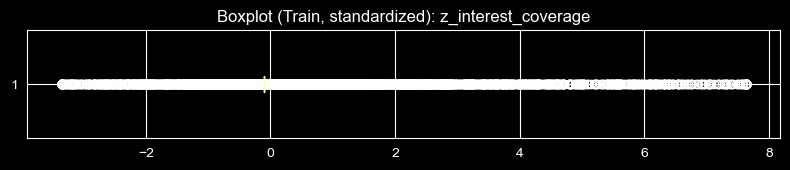

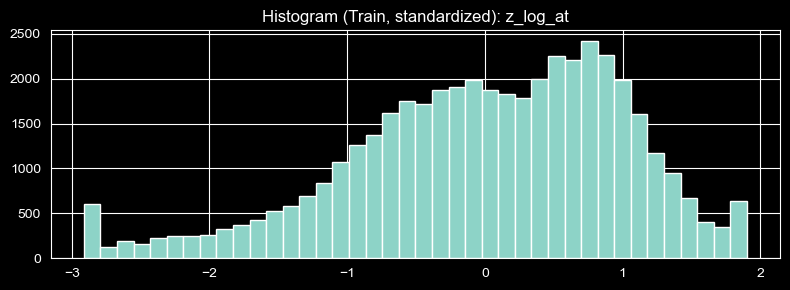

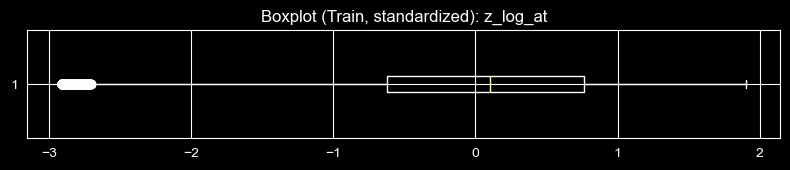

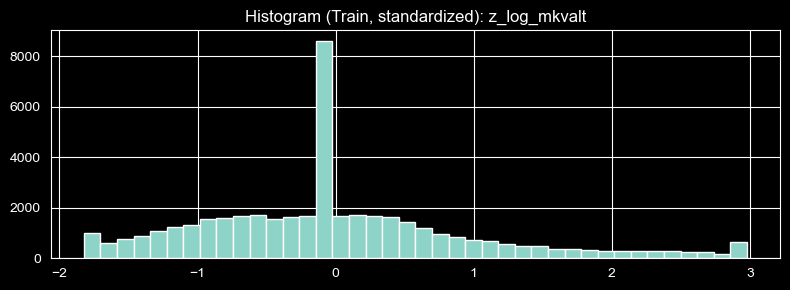

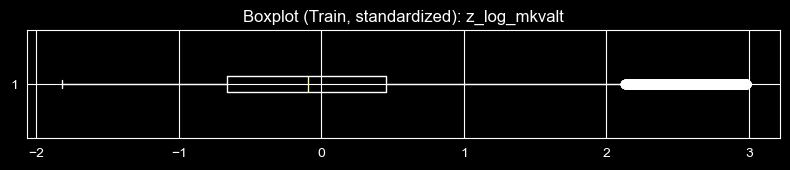


----- Rolling Year CV folds (within TRAIN_POOL) -----
Fold 1: train_years=2015..2017 (n=19775), val_year=2018 (n=6337)
Fold 2: train_years=2015..2018 (n=26112), val_year=2019 (n=6173)
Fold 3: train_years=2015..2019 (n=32285), val_year=2020 (n=6233)
Fold 4: train_years=2015..2020 (n=38518), val_year=2021 (n=6265)
Fold 5: train_years=2015..2021 (n=44783), val_year=2022 (n=6415)

----- Final feature availability -----
Model features: ['z_roa', 'z_cf_roa', 'z_leverage', 'z_debt_to_equity', 'z_current_ratio', 'z_cash_ratio', 'z_re_to_assets', 'z_mkt_to_book', 'z_capex_ratio', 'z_interest_coverage', 'z_log_at', 'z_log_mkvalt', 'miss_roa', 'miss_cf_roa', 'miss_leverage', 'miss_debt_to_equity', 'miss_current_ratio', 'miss_cash_ratio', 'miss_re_to_assets', 'miss_mkt_to_book', 'miss_capex_ratio', 'miss_interest_coverage', 'miss_log_at', 'miss_log_mkvalt']
Train: (44783, 25)
Val:   (6415, 25)
Test:  (12404, 25)

----- df (full, post-target construction) -----
                gvkey               

In [8]:

# =============================================================================
# 5. FEATURE ENGINEERING (Create/transform features for modeling)
# =============================================================================
# 5.1 Create ratio features (applied to each split; deterministic, no leakage)
train = _add_ratio_features(train)
val   = _add_ratio_features(val)
test  = _add_ratio_features(test)

base_features = [
    'roa', 'cf_roa', 'leverage', 'debt_to_equity', 'current_ratio',
    'cash_ratio', 're_to_assets', 'mkt_to_book', 'capex_ratio', 'interest_coverage'
]
base_features = [c for c in base_features if (c in train.columns and c in val.columns and c in test.columns)]

# 5.2 Log features (size-related; non-negative)
for split in [train, val, test]:
    _add_log_features(split, cols=['at', 'mkvalt', 'sale'])

log_features = [c for c in ['log_at', 'log_mkvalt'] if (c in train.columns and c in val.columns and c in test.columns)]

# 5.3 Missing indicators for engineered features (capture signal from missingness)
miss_flags = []
for c in base_features + log_features:
    flag = f"miss_{c}"
    train[flag] = pd.to_numeric(train[c], errors='coerce').isna().astype(int)
    val[flag]   = pd.to_numeric(val[c], errors='coerce').isna().astype(int)
    test[flag]  = pd.to_numeric(test[c], errors='coerce').isna().astype(int)
    miss_flags.append(flag)

# 5.4 Impute engineered features (fit on TRAIN only; apply to VAL/TEST)
#     Note: this is separate from raw imputation because ratios/logs can create NaNs (e.g., denom=0, negatives for log).
engineered_cols = base_features + log_features
if APPLY_TRAIN_MEDIAN_IMPUTE and engineered_cols:
    medians_eng = _fit_medians(train, engineered_cols)
    train = _apply_median_impute(train, medians_eng)
    val   = _apply_median_impute(val,   medians_eng)
    test  = _apply_median_impute(test,  medians_eng)

# 5.5 Winsorization + standardization (fit on TRAIN only; apply to VAL/TEST)
winsor_cols = [c for c in engineered_cols if (c in train.columns and c in val.columns and c in test.columns)]

winsor_bounds = _fit_winsor_bounds(train, winsor_cols, q_lo=WINSOR_LOWER_Q, q_hi=WINSOR_UPPER_Q)
train = _apply_winsor(train, winsor_bounds)
val   = _apply_winsor(val,   winsor_bounds)
test  = _apply_winsor(test,  winsor_bounds)
print("Winsorization done (bounds fit on TRAIN only).")

scaler_stats = _fit_scaler(train, winsor_cols)
train = _apply_zscore(train, scaler_stats, prefix="z_")
val   = _apply_zscore(val,   scaler_stats, prefix="z_")
test  = _apply_zscore(test,  scaler_stats, prefix="z_")
print("Standardization done (stats fit on TRAIN only).")

# Final modeling feature set (example): standardized engineered features + missingness indicators
model_features = [f"z_{c}" for c in winsor_cols] + miss_flags

# =============================================================================
# 6. POST-FE DIAGNOSTICS (Train only)
# =============================================================================
target_col = 'target_next_year_distress'

print("\n----- Correlation with Target (TRAIN; standardized engineered features) -----")
if model_features:
    corr_df = train[[target_col] + model_features].corr(numeric_only=True)
    for c in model_features:
        r = corr_df.loc[target_col, c]
        print(f"{c:<25} r = {r: .4f}")

print("\n----- Variability Checks (TRAIN; standardized engineered features) -----")
for c in [f"z_{x}" for x in winsor_cols]:
    if c not in train.columns:
        continue
    s = pd.to_numeric(train[c], errors='coerce').dropna()
    if s.empty:
        print(f"{c:<25} IQR: NA, Std. Dev.: NA")
        continue
    iqr = s.quantile(0.75) - s.quantile(0.25)
    std = s.std(ddof=1)
    print(f"{c:<25} IQR: {iqr:.6f}, Std. Dev.: {std:.6f}")

# Optional: quick distribution plots (train) AFTER winsor+zscore for core features
for c in [f"z_{x}" for x in winsor_cols]:
    if c not in train.columns:
        continue
    s = pd.to_numeric(train[c], errors='coerce').dropna()
    if s.empty:
        continue

    plt.figure(figsize=(8, 3))
    plt.hist(s.values, bins=40)
    plt.title(f"Histogram (Train, standardized): {c}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 1.8))
    plt.boxplot(s.values, vert=False)
    plt.title(f"Boxplot (Train, standardized): {c}")
    plt.tight_layout()
    plt.show()

# =============================================================================
# 7. ROLLING / FORWARD CV BY YEAR (No model training; just splits)
# =============================================================================
def rolling_year_folds(df_in, year_col='label_year', n_splits=5, min_train_years=3):
    years = np.sort(df_in[year_col].dropna().unique())
    if len(years) < (min_train_years + n_splits):
        n_splits = max(1, len(years) - min_train_years)
    folds = []
    for k in range(n_splits):
        train_years = years[:min_train_years + k]
        val_year = years[min_train_years + k]
        tr_idx = df_in.index[df_in[year_col].isin(train_years)].to_numpy()
        va_idx = df_in.index[df_in[year_col] == val_year].to_numpy()
        folds.append((tr_idx, va_idx, train_years, val_year))
    return folds

print("\n----- Rolling Year CV folds (within TRAIN_POOL) -----")
train_pool_for_cv = train_pool.copy()  # includes train+val by construction (excludes test)
year_folds = rolling_year_folds(train_pool_for_cv, year_col='label_year',
                                n_splits=N_SPLITS_TIME_CV, min_train_years=3)

for i, (tr_idx, va_idx, tr_years, va_year) in enumerate(year_folds, 1):
    print(f"Fold {i}: train_years={tr_years[0]}..{tr_years[-1]} (n={len(tr_idx)}), "
          f"val_year={va_year} (n={len(va_idx)})")

# =============================================================================
# 8. FINAL QUICK CHECKS
# =============================================================================
print("\n----- Final feature availability -----")
print("Model features:", model_features)
print("Train:", train[[target_col] + model_features].shape)
print("Val:  ", val[[target_col] + model_features].shape)
print("Test: ", test[[target_col] + model_features].shape if not test.empty else "Test is empty")

print("\n----- df (full, post-target construction) -----")
print(df.describe(include='all'))

